# Fourier analysis

1. Load the PKL file containing resampled P
2. Show statistics of signals
2. Calculate FFT, i.e., frequency - amplitude/phase pairs
2. Select some of the frequencies and save
3. Reconstruct signal from sampled FFT
5. Compare power density spectra

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, random

from math import pi
from scipy.signal import welch

In [2]:
def reconstruct(time,frequencies,sampled_dft,scale):
    # Set shape of signal
    signal = np.zeros_like(time)
    
    # Inverse FFT?
    for f,a in zip(frequencies,sampled_dft):
        if f == 0:
            signal += a.real/2.0
        else:
            signal += a.real * np.cos(time*2*pi*f) -\
                      a.imag * np.sin(time*2*pi*f)

    # Normalize the signal
    signal /= scale
    return signal

In [3]:
# Load data
RAWFILE = "pickledData_constg/PTX(3).pkl"
with open(RAWFILE,'rb') as f: P = pickle.load(f)

In [4]:
# Calculate DFT
dT, nP = P.index[1] - P.index[0], len(P)
fourier = pd.DataFrame({'Freq':np.fft.rfftfreq(nP,d=dT)})
fourier.set_index("Freq",inplace=True)
for col in P: fourier[col] = np.fft.rfft(P[col])

In [5]:
# Select a portion of frequencies to reconstruct the signal with
#sampled = fourier.loc[fourier.index < 10.0]
sampled = fourier.iloc[:1024,:]
time_arr = np.array(list(P.index))
highestFreqCaptured = sampled.index[-1]

print("""
{:} frequencies are used for signal reconstruction
{:.2f} Hz is the highest frequency conserved
""".format(len(sampled),highestFreqCaptured))


1024 frequencies are used for signal reconstruction
10.73 Hz is the highest frequency conserved



In [6]:
# Reconstruct one signal to visualize
nWhich = int(0)
Pnew = reconstruct(time_arr,sampled.index,sampled.iloc[:,nWhich],len(fourier))
Pold = P.iloc[:,nWhich]

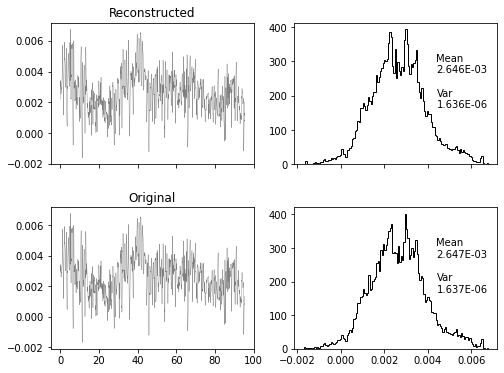

In [7]:
# Plot signals with histograms
line_dict = dict(c='k',alpha=0.5,lw=0.4)
hist_dict = dict(bins='sqrt',density=True,histtype='step',color='k')
fig,ax = plt.subplots(2,2,sharex='col',figsize=[8,6],gridspec_kw={'hspace':0.3})

## Reconstructed
ax[0,0].plot(P.index,Pnew,**line_dict)
ax[0,0].set_title("Reconstructed")
ax[0,1].hist(Pnew,**hist_dict)
ax[0,1].text(0.7,0.4,"Mean\n{:.3E}\n\nVar\n{:.3E}".format(Pnew.mean(),Pnew.var()),\
             transform=ax[0,1].transAxes)


## Original
ax[1,0].plot(P.index,Pold,**line_dict)
ax[1,0].set_title('Original')
ax[1,1].hist(Pold,**hist_dict)
ax[1,1].text(0.7,0.4,"Mean\n{:.3E}\n\nVar\n{:.3E}".format(Pold.mean(),Pold.var()),\
             transform=ax[1,1].transAxes)

plt.show()

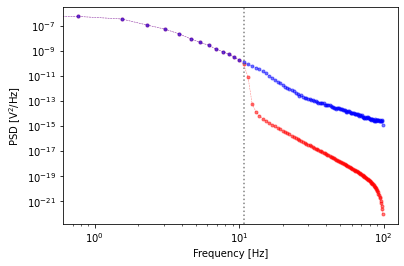

In [8]:
# Compare power spectral density plots

line_dict  = dict(ls='dashed',marker='.',lw=0.5,alpha=0.5)
welch_dict = dict(fs=1/dT,scaling='density')
fig,ax = plt.subplots()

# Reconstructed
f,Pxx= welch(Pnew,**welch_dict)
ax.plot(f,Pxx,label="Reconstructed",**line_dict,c='r')

# Original
f,Pxx= welch(Pold,**welch_dict)
ax.plot(f,Pxx,label="Original",**line_dict,c='b')

ax.axvline(x=highestFreqCaptured,ls='dotted',c='gray')
ax.set(xscale='log',yscale='log',\
       xlabel=r"Frequency [Hz]",ylabel=r"PSD [V$^2$/Hz]")
plt.show()

NumExpr defaulting to 8 threads.


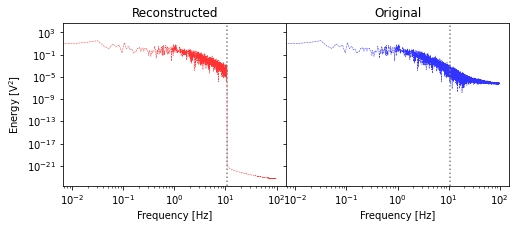

In [9]:
# Compare magnitude spectra

line_dict  = dict(ls='dashed',lw=0.5,alpha=0.8)
fig,axs = plt.subplots(1,2,sharey=True,figsize=[8,3],gridspec_kw={"wspace":0})

# Reconstructed
f, Sxx = np.fft.rfftfreq(len(Pnew),d=dT), np.absolute(np.fft.rfft(Pnew))**2
axs[0].plot(f,Sxx,**line_dict,c='r')
axs[0].set(ylabel=r"Energy [V$^2$]",title="Reconstructed")

# Original
f, Sxx = fourier.index, np.absolute(fourier.iloc[:,nWhich])**2
axs[1].plot(f,Sxx,**line_dict,c='b')
axs[1].set(title="Original")

for ax in axs: 
    ax.axvline(x=highestFreqCaptured,ls='dotted',c='gray')
    ax.set(xscale='log',yscale='log',xlabel=r"Frequency [Hz]")

plt.show()

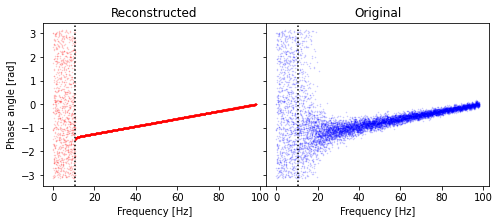

In [10]:
# Compare phase spectra

line_dict  = dict(ls='dashed',lw=0,alpha=0.2,marker='.',ms=1)
fig,axs = plt.subplots(1,2,sharey=True,figsize=[8,3],gridspec_kw={"wspace":0})

# Reconstructed
f, Sxx = np.fft.rfftfreq(len(Pnew),d=dT), np.angle(np.fft.rfft(Pnew))
axs[0].plot(f,Sxx,**line_dict,c='r')
axs[0].set(ylabel=r"Phase angle [rad]",title="Reconstructed")

# Original
f, Sxx = fourier.index, np.angle(fourier.iloc[:,nWhich])
axs[1].plot(f,Sxx,**line_dict,c='b')
axs[1].set(title="Original")

for ax in axs: 
    ax.axvline(x=highestFreqCaptured,ls='dotted',c='k')
    ax.set(xscale='linear',yscale='linear',xlabel=r"Frequency [Hz]")

plt.show()

In [11]:
# Pickle data
fname = "pickledData_constg/PTX(4).pkl"
with open(fname,'wb') as f: pickle.dump(sampled,f)

### Important numbers to keep

In [12]:
print(f"Scale factor = {len(fourier)}")

Scale factor = 9351


In [13]:
print(f"Number of X = {len(P.columns)}")

Number of X = 51


In [14]:
print(f"Delta freq  = {fourier.index[1]}")

Delta freq  = 0.010490823962563048
